In [7]:
import os
import random
import time
import torch
import torch.nn as nn
import numpy as np

from colbert.modeling.colbert import ColBERT
from colbert.utils.utils import print_message
from colbert.training.utils import print_progress, manage_checkpoints

query_maxlen = 512
query_maxlen = 512
doc_maxlen = 512
dim = 128
similarity = 'cosine'

colbert = ColBERT.from_pretrained('bert-base-uncased', query_maxlen=query_maxlen, doc_maxlen=doc_maxlen, dim=dim, similarity_metric=similarity, mask_punctuation=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ColBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['linear.weight']
You should probably TRAI

In [1]:
from tensor_net1 import TTLayer

In [3]:
print(sum(p.numel() for p in colbert.parameters()))

109580544


In [13]:
fc_w = colbert.bert.encoder.layer[3].intermediate.dense
fc_b = colbert.bert.encoder.layer[3].intermediate.dense.bias
print(sum(p.numel() for p in fc_w.weight))

2359296


In [17]:
print(sum(p.numel() for p in fc_b))

3072


In [16]:
TT_SHAPES = (32, 48, 48, 32)
TT_RANKS = [1, 380, 390, 380, 1] # comp rate 0.5
SVD_RANKS = 350


fc_w = colbert.bert.encoder.layer[3].intermediate.dense
fc_b = colbert.bert.encoder.layer[3].intermediate.dense.bias

(out_, in_) = fc_w.weight.shape
print (out_, in_)
factorized_layer = TTLayer(fc_w, shapes = TT_SHAPES, in_dims = [32, 24], ranks = TT_RANKS)
print (factorized_layer.cores)
print(sum(p.numel() for p in factorized_layer.parameters()))

3072 768
layer.shape torch.Size([3072, 768])
ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x32x32]
    (1): Parameter containing: [torch.FloatTensor of size 32x48x390]
    (2): Parameter containing: [torch.FloatTensor of size 390x48x32]
    (3): Parameter containing: [torch.FloatTensor of size 32x32x1]
)
1203200


## TT

In [4]:
TT_SHAPES = [32, 48, 48, 32]
TT_RANKS = [450, 450, 450]

for i in [0, 2, 4, 6, 8, 10]:
    # fc part
    fc_w = colbert.bert.encoder.layer[i].intermediate.dense
    fc_b = colbert.bert.encoder.layer[i].intermediate.dense.bias
    (out_, in_) = fc_w.weight.shape
    print (out_, in_)
    factorized_layer = TTLayer(fc_w, shapes = TT_SHAPES, in_dims = [32, 24], ranks = TT_RANKS)
    print (factorized_layer.cores)
    for elem in factorized_layer.cores:
        print (elem.shape)
        
    colbert.bert.encoder.layer[i].intermediate.dense = factorized_layer
            
    fc_w = colbert.bert.encoder.layer[i].output.dense
    factorized_layer = TTLayer(fc_w, shapes = TT_SHAPES, in_dims = [32, 48, 2], ranks = TT_RANKS)
    colbert.bert.encoder.layer[i].output.dense = factorized_layer

3072 768
ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x32x32]
    (1): Parameter containing: [torch.FloatTensor of size 32x48x450]
    (2): Parameter containing: [torch.FloatTensor of size 450x48x32]
    (3): Parameter containing: [torch.FloatTensor of size 32x32x1]
)
torch.Size([1, 32, 32])
torch.Size([32, 48, 450])
torch.Size([450, 48, 32])
torch.Size([32, 32, 1])
3072 768
ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x32x32]
    (1): Parameter containing: [torch.FloatTensor of size 32x48x450]
    (2): Parameter containing: [torch.FloatTensor of size 450x48x32]
    (3): Parameter containing: [torch.FloatTensor of size 32x32x1]
)
torch.Size([1, 32, 32])
torch.Size([32, 48, 450])
torch.Size([450, 48, 32])
torch.Size([32, 32, 1])
3072 768
ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x32x32]
    (1): Parameter containing: [torch.FloatTensor of size 32x48x450]
    (2): Parameter containing: [torch.FloatT

In [15]:
print(sum(p.numel() for p in colbert.bert.encoder.layer[2].output.dense.parameters()))

1385216


In [5]:
print(sum(p.numel() for p in colbert.parameters()))

97882368


## TTM

In [8]:
import numpy as np
import torch
from torch import nn
import tntorch as tn

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')



def matrix_to_tt_cores(matrix, shapes, ranks):
  shapes = np.asarray(shapes)
  matrix = matrix.reshape(list(shapes.flatten()))
  print (matrix.shape)
  d = len(shapes[0])
  transpose_idx = list(np.arange(2 * d).reshape(2, d).T.flatten())
  matrix = matrix.permute(*transpose_idx)
  print (matrix.shape)
  newshape = np.prod(shapes, 0)
  matrix = matrix.reshape(list(newshape))
  print (matrix.shape)
  #tt = tn.Tensor(matrix, ranks_tt=ranks)
  tt = tensor_train(full, rank = ranks)



  newcores = []
  for core, s1, s2, r1, r2 in zip(tt.cores,
                                  shapes[0], shapes[1],
                                  tt.ranks_tt, tt.ranks_tt[1:]):
    newcores.append(core.reshape((r1, s1, s2, r2)))
  return newcores


def ttmatmul(cores, t, shapes, ranks):
  ranks = [1] + ranks + [1]
  tshape = t.shape

  t = t.transpose(1, 0)
  t = t.reshape((-1, shapes[1][-1], 1))
  ndims = len(cores)
  for i in reversed(range(ndims)):
    t = torch.einsum('aijb,rjb->ira', (cores[i], t))
    if i:
      t = t.reshape((-1, shapes[1][i - 1], ranks[i]))
  t = t.reshape((int(np.prod(shapes[0])), tshape[1]))
  return t


def transpose(cores):
    result = []
    for c in cores:
        result.append(c.permute((0, 2, 1, 3)))
    return result


def matmultt(t, cores, shapes, ranks):
    #t = t.transpose(1, 0)
    #cores = transpose(cores)
    shapes = [shapes[1], shapes[0]]
    return ttmatmul(cores, t, shapes, ranks).transpose(1, 0)


class TTLayer(nn.Module):
    def __init__(self, layer, ranks):
        super(TTLayer, self).__init__()
        self.ranks = ranks
        with torch.no_grad():
            #weight = layer.weight.transpose(1, 0)
            self.cores = nn.ParameterList(
            map(nn.Parameter, tensor_train(layer, rank = ranks)))
        #self.bias = layer.bias

    def forward(self, inputs):
        out = matmultt(inputs, self.cores, self.shapes, self.ranks)
        out = out + self.bias
        return out


In [30]:
m = torch.rand(11*23, 3*2, 2*3)
v = torch.rand(30, 11 * 3 *2)  # Note: batch = 30, 11 * 3 features
m.shape

torch.Size([253, 6, 6])

In [33]:
tt = tensor_train(m, rank = [1, 36, 6, 1])

In [27]:
input_dims = [11, 3, 2]
output_dims = [23, 2, 3]
ranks = [50, 50]

ttm = tn.TTMatrix(m, input_dims=input_dims, output_dims=output_dims, ranks=ranks)

In [28]:
ttm.input_dims

tensor([11,  3,  2])

In [34]:
a = tn.tt_multiply(tt, v)
print (a.shape)

AttributeError: 'TTTensor' object has no attribute 'input_dims'

In [29]:
for elem in ttm.cores:
    print (elem.shape)

torch.Size([1, 11, 23, 36])
torch.Size([36, 3, 2, 6])
torch.Size([6, 2, 3, 1])


In [14]:
v.shape

torch.Size([30, 33])

In [ ]:
def test_tt_multiply():
    m = torch.rand(11 * 3, 23 * 2)
    v = torch.rand(30, 11 * 3)  # Note: batch = 30, 11 * 3 features

    input_dims = [11, 3]
    output_dims = [23, 2]
    ranks = [50]

    ttm = tn.TTMatrix(m, input_dims=input_dims, output_dims=output_dims, ranks=ranks)
    assert torch.allclose(v @ m, tn.tt_multiply(ttm, v))

    cpm = tn.CPMatrix(m, input_dims=input_dims, output_dims=output_dims, rank=ranks[0])
    assert torch.allclose(v @ m, tn.cp_multiply(cpm, v))


In [10]:
fc_w = colbert.bert.encoder.layer[4].intermediate.dense.weight.data.cpu()
fc = colbert.bert.encoder.layer[4].intermediate.dense

In [11]:
new_layer = TTLayer(fc_w.reshape(32, 48, 48, 32), ranks = [1, 380, 390, 380, 1])

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [ ]:
torch.rand(2, 3)

In [12]:
for elem in new_layer.cores:
    print (elem.shape)

torch.Size([1, 32, 32])
torch.Size([32, 48, 390])
torch.Size([390, 48, 32])
torch.Size([32, 32, 1])


In [ ]:
def tt_multiply(tt_matrix: TTMatrix, tensor: torch.Tensor):
    """
    Multiply TTMatrix by any tensor of more than 1-way.
    For vectors, reshape them to matrix of shape 1 x I
    returns: torch.Tensor of shape b x num_cols(tt_matrix)
    """

    assert len(tensor.shape) > 1

    rows = torch.prod(tt_matrix.input_dims)
    b = tensor.reshape(-1, rows).shape[0]
    tensor = tensor.reshape(b, -1).T
    result = tensor.reshape(tt_matrix.input_dims[0], -1)
    result = torch.einsum('id,lior->ldor', result, tt_matrix.cores[0])

    for d in range(1, tt_matrix.d):
        result = result.reshape(tt_matrix.input_dims[d], -1, tt_matrix.cores[d].shape[0])
        result = torch.einsum('idr,riob->dob', result, tt_matrix.cores[d])

    return result.reshape(b, -1)

In [ ]:
d_out_modes = [4, 4, 8, 4, 4]
d_in_modes = [2, 4, 8, 4, 2]

tt_ranks = [1, 2, 2, 2, 2, 1]
tt_ranks2 = [ 1,  1, 16, 54,  6,  1]
tt_ranks3 = [1, 4, 4, 4, 4, 1]
tt_ranks4 = [1, 2, 4, 4, 2, 1]
tt_ranks8 = [1, 2, 4, 8, 4, 2, 1]

self.w_1 = ttm.TTLayer(d_in_modes, d_out_modes, tt_ranks3, bias=False)
self.w_2 = ttm.TTLayer(d_out_modes,d_in_modes, tt_ranks4, bias=False)

In [11]:
new_layer = TTLayer(in_modes = [32, 48, 48, 32], out_modes = [48,32,48, 32], ranks = [1, 380, 390, 380, 1])

2


In [12]:
for elem in new_layer.weight:
    print (elem.shape)

torch.Size([18240, 32])
torch.Size([12480, 18240])
torch.Size([18240, 18720])
torch.Size([32, 12160])


In [ ]:
fc.reshape(32, 48, 48, 32)

In [ ]:
fc_w_new.weight.shape

**singular values**

In [ ]:
u,s,vh = np.linalg.svd(model.fc1.weight.cpu().detach().numpy())
plt.plot(s)
print (s[0:1], s[len(s)-2: len(s)-1])
plt.show()

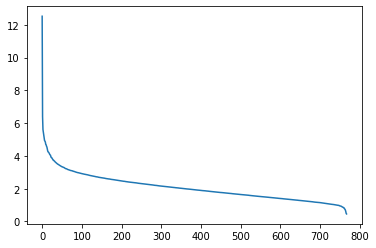

In [14]:
plt.plot(s)
plt.show()

In [6]:
{6:(0, 2, 4, 1, 3, 5), 8:(0, 2, 4, 6, 1, 3, 5, 7), 10:(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

{6: (0, 2, 4, 1, 3, 5),
 8: (0, 2, 4, 6, 1, 3, 5, 7),
 10: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}

In [7]:
a = colbert.bert.encoder.layer[4].intermediate.dense(input_)

NameError: name 'input_' is not defined

In [8]:
b = fc_w_new(input_)

NameError: name 'input_' is not defined